In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/natural-language-processing")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Check GPU and install dependencies
!pip install simpletransformers tensorboardx nltk transformers tf-keras tensorflow
import logging, random, pandas as pd, torch
from collections import Counter
from ast import literal_eval
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from urllib import request
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from dont_patronize_me import DontPatronizeMe
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from transformers import pipeline
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print('Cuda available? ', cuda_available)

if cuda_available:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')


Cuda available?  False


In [4]:
# Fetch the Don't Patronize Me! data manager module
module_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name, 'w') as outf:
    outf.write(f.read().decode('utf-8'))
dpm = DontPatronizeMe('./data/train/original_data', './data/train/original_data')
dpm.load_task1()
dpm.load_task2(return_one_hot=False)


Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


Task1 df columns: Index(['par_id', 'art_id', 'keyword', 'country', 'text', 'label',
       'orig_label'],
      dtype='object')
   par_id
0    4046
1    1279
2    8330
3    4063
4    4089
   par_id  pred_label
0    4046           0
1    1279           1
2    8330           0
3    4063           1
4    4089           1
   par_id  label orig_label  pred_label
0     107      1          3           0
1     149      1          2           0
2     151      1          3           0
3     154      1          4           1
4     157      1          4           0
2094


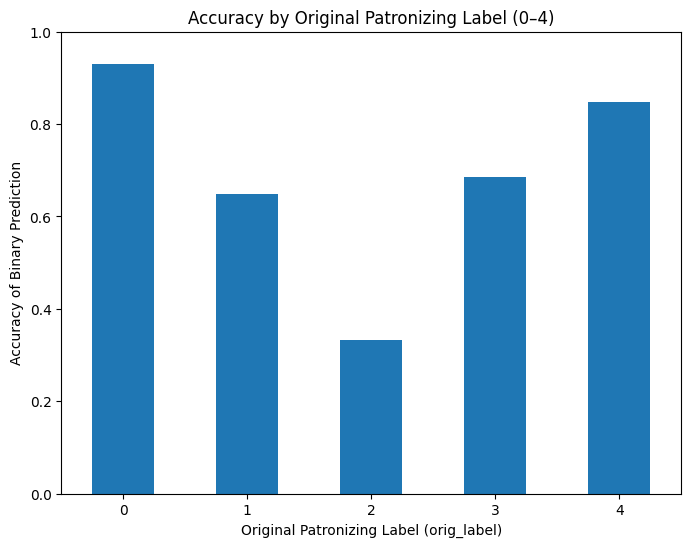

In [5]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# 1) Load Task 1 data (0..4 labels + orig_label)
dpm = DontPatronizeMe('./data/train/original_data', './data/test/')
dpm.load_task1()

# dpm.train_task1_df has columns:
#   ['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']
df_cats = dpm.train_task1_df
print("Task1 df columns:", df_cats.columns)

# 2) Load dev set par_ids only
df_dev_labels = pd.read_csv('./data/train/sample_splits/dev_semeval_parids-labels.csv', usecols=['par_id'])
print(df_dev_labels.head())

# 3) Load predicted labels (0..4) from dev.txt, one integer per line
preds = []
with open('dev.txt', 'r') as f:
    for line in f:
        label = int(line.strip())  # e.g. "0", "1", "2", "3", or "4"
        preds.append(label)

df_dev_labels['pred_label'] = preds
print(df_dev_labels.head())

# 4) Merge dev DataFrame with Task1 DataFrame on 'par_id'
df_cats['par_id']       = df_cats['par_id'].astype(int)
df_dev_labels['par_id'] = df_dev_labels['par_id'].astype(int)

# Include `orig_label` so we have both the numeric (0..4) and its original string
df_merged = pd.merge(
    df_cats[['par_id','label','orig_label']],   # ground-truth label (0..4) + original string
    df_dev_labels[['par_id','pred_label']],     # predicted 0..4
    on='par_id',
    how='inner'
)
print(df_merged.head())

# 1) Convert orig_label to int if it’s stored as string
df_merged['orig_label'] = df_merged['orig_label'].astype(int)

# 2) Create a "correct" column: 1 if label == pred_label, else 0
df_merged['correct'] = (df_merged['label'] == df_merged['pred_label']).astype(int)
print(len(df_merged))
# 3) Group by orig_label and compute mean of "correct".
#    Because "correct" is 1 for correct and 0 for wrong,
#    the average is exactly the accuracy for that orig_label.
accuracy_per_orig = df_merged.groupby('orig_label')['correct'].mean()

# 4) Plot a bar chart: x = orig_label, y = accuracy
plt.figure(figsize=(8,6))
accuracy_per_orig.plot(kind='bar')
plt.title("Accuracy by Original Patronizing Label (0–4)")
plt.xlabel("Original Patronizing Label (orig_label)")
plt.ylabel("Accuracy of Binary Prediction")
plt.ylim(0,1)
plt.xticks(rotation=0)  # keep labels horizontal if you like
plt.show()
